In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import listdir
from os.path import isfile, join
import os
import shutil
from tqdm import tqdm
from PIL import Image



#bucket.put_object(Bucket='baudoin-bucket',Body='', Key='cropped_images/')

local_dataset_path = '/home/baudoin/data/zurich_data/images/'
cropped_images_dir = '/home/baudoin/data/zurich_data/cropped_images/'

classes_path = '/home/baudoin/pytorch-retinanet-pipeline/annotations/visdrone_anno/class_labels.csv'
model_path ='/home/baudoin/pytorch-retinanet-pipeline/results/training_results/20220209-193813/checkpoints/best_model_retinanet_csv.pt'

nb_tiles = 3
MinConfidence = 50
#allowed_labels = ['Person', 'Car']
output_annotation_file = '/home/baudoin/pytorch-retinanet-pipeline/annotations/zurich_anno/anno.csv'

images_path = [local_dataset_path + f for f in listdir(local_dataset_path) if isfile(join(local_dataset_path, f))]
print(images_path)
def uploadDirectory_to_s3(path, upload_path, bucket):
  print(f'Uploading directory {path} to S3 Bucket')
  for root,dirs,files in os.walk(path):
      for file in tqdm(files):
          bucket.upload_file(os.path.join(root,file),upload_path + file)

def save_tiles_to_local_dir(tiles_data, folder_path, anno=False):
  if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
  os.makedirs(folder_path, exist_ok=True)
  tiles_paths = []
  for idx, w in enumerate(tiles_data):
    img_to_save_path = folder_path + '/' + 'tile_' + str(idx) + '.jpg'
    img_to_save = Image.fromarray(w[2])
    img_to_save.save(img_to_save_path)
    #break
    if anno:
      tiles_paths.append(img_to_save_path)
  
  if anno:
    with open(folder_path + '/' + 'anno.csv', 'w') as csv_file:
      for tile_path in tiles_paths:
        csv_file.write(tile_path + ',' + ','.join(['','','', '']) + ',' + '' + '\n')


def filter_Rekognition_labels(response, allowed_labels):
  detected_objects = []
  for label in response['Labels']:
    if label['Name'] in allowed_labels:
      res = {}
      if label['Instances']:
        for instance in label['Instances']:
          bbox = instance['BoundingBox']
          res['Label']=label['Name']
          res = {**res, **bbox}
          detected_objects.append(res)
                
  return detected_objects

def sliding_window(image, stepSize, windowSize):
  for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
      yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def get_tiles_metadata(tiles_data):
  metadata = []
  for w in tiles_data:
    metadata.append([w[0],w[1],w[2].shape[0], w[2].shape[1]])
  return metadata

def detect_lables_retinanet_superpoint(tiles_anno_path, classes_path, model_path):
	import torch
	import torch.nn.functional as F
	from torch.utils.data import Dataset, DataLoader
	from torchvision import datasets, models, transforms

	from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, \
		AspectRatioBasedSampler, Augmenter, UnNormalizer, Normalizer
	from retinanet import model
	tiles_data = CSVDataset(train_file=tiles_anno_path, class_list=classes_path, transform=transforms.Compose([Normalizer(), Resizer()]))

	sampler_val = AspectRatioBasedSampler(tiles_data, batch_size=1, drop_last=False)
	dataloader_val = DataLoader(tiles_data, num_workers=1, collate_fn=collater, batch_sampler=sampler_val)

	retinanet = model.resnet50(num_classes=tiles_data.num_classes(), pretrained=True)
	retinanet = torch.nn.DataParallel(retinanet)

	checkpoint = torch.load(model_path)
	retinanet.load_state_dict(checkpoint['model'])

	if torch.cuda.is_available():
		retinanet = torch.nn.DataParallel(retinanet).cuda()
	else:
		retinanet = torch.nn.DataParallel(retinanet)

	retinanet.eval()

	unnormalize = UnNormalizer()
	detected_objects_per_image = []
	for idx, data in enumerate(dataloader_val):		
		with torch.no_grad():
			if torch.cuda.is_available():
				scores, classification, transformed_anchors, output = retinanet([data['img'].cuda().float(), data['annot']])
			else:
				scores, classification, transformed_anchors, output = retinanet([data['img'].float(), data['annot']])
		
			idxs = np.where(scores.cpu()>0.5)
			img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()
			img[img<0] = 0
			img[img>255] = 255
			img = np.transpose(img, (1, 2, 0))
			detected_objects_per_tile = []
			for j in range(idxs[0].shape[0]):
				bbox = transformed_anchors[idxs[0][j], :]
				obj = {}
				obj['Label'] = tiles_data.labels[int(classification[idxs[0][j]])]
				obj['x1'] = int(bbox[0])
				obj['y1'] = int(bbox[1])
				obj['x2'] = int(bbox[2])
				obj['y2'] = int(bbox[3])
				detected_objects_per_tile.append(obj)

		detected_objects_per_image.append(detected_objects_per_tile)

	return detected_objects_per_image


def convert_bbox_format(detected_objects_per_image, tiles_metadata):
  new_objects = []
  idx = 0
  for objects_per_tile in detected_objects_per_image:
    for obj in objects_per_tile:
      new_obj = {}
      new_obj['x1'] = tiles_metadata[idx][0] + int(obj['x1'])
      new_obj['y1'] = tiles_metadata[idx][1] + int(obj['y1'])
      new_obj['x2'] = tiles_metadata[idx][0] + int(obj['x2'])
      new_obj['y2'] = tiles_metadata[idx][1] + int(obj['y2'])
      new_obj['Label'] = obj['Label']      
      new_objects.append(new_obj)
    idx += 1
  return new_objects

def save_annotations(detected_objects, img_path, output_annotation_file):
  with open(output_annotation_file, 'w') as csv_file:
    for obj in detected_objects:
      label = obj['Label']
      x1 = obj['x1']
      y1 = obj['y1']
      x2 = obj['x2']
      y2 = obj['y2']
      if x1==0 and y1==0 and x2==0 and y2==0:
        csv_file.write(img_path + ',' + ','.join(['','','', '']) + ',' + '' + '\n')
      else:
        csv_file.write(img_path + ',' + ','.join([str(x1),str(y1),str(x2), str(y2)]) + ',' + label + '\n')


for img_path in images_path:
  image = Image.open(img_path)
  img = np.asarray(image)

  #window_H = int(img.shape[0]/nb_tiles)
  #window_W = int(img.shape[1]/nb_tiles)
  #step_size = int(0.9*min(window_H, window_W))

  window_H = 1000
  window_W = 1000
  step_size = 1000

  tiles_data = sliding_window(img, step_size, (window_H, window_W))
  tiles_metadata = get_tiles_metadata(sliding_window(img, step_size, (window_H, window_W)))
  
  full_img_name = Path(img_path).stem
  folder_path = cropped_images_dir + full_img_name
  
  save_tiles_to_local_dir(tiles_data, folder_path, anno=True)
  tiles_anno_path = folder_path + '/' + 'anno.csv'
  detected_objects_per_image = detect_lables_retinanet_superpoint(tiles_anno_path, classes_path, model_path)
  detected_objects = convert_bbox_format(detected_objects_per_image, tiles_metadata)
  

  break
  
  #uploadDirectory_to_s3(folder_path, full_img_name + '/', bucket)
  """
  detected_objects_per_image = []
  for img_obj in bucket.objects.filter(Prefix=full_img_name + '/'):
    image = {'S3Object': {'Bucket': BUCKET, 'Name': img_obj.key}}
    response = Rekognition_client.detect_labels(Image=image, MinConfidence=MinConfidence)
    detected_objects_per_tile = filter_Rekognition_labels(response, allowed_labels)
    detected_objects_per_image.append(detected_objects_per_tile)
  

  detected_objects = convert_bbox_format(detected_objects_per_image, tiles_metadata)
  save_annotations(detected_objects, img_path, output_annotation_file)
  
  break"""
 

    


['/home/baudoin/data/zurich_data/images/20210411_zh4_Flight_02_01060.jpg', '/home/baudoin/data/zurich_data/images/20210411_zh4_Flight_02_00516.jpg', '/home/baudoin/data/zurich_data/images/20210411_zh4_Flight_02_00962.jpg', '/home/baudoin/data/zurich_data/images/20210411_zh4_Flight_02_01259.jpg']


In [6]:
print(detected_objects)

[{'x1': 1491, 'y1': 12, 'x2': 1536, 'y2': 54, 'Label': 'pedestrian'}, {'x1': 1481, 'y1': 432, 'x2': 1518, 'y2': 475, 'Label': 'people'}, {'x1': 2537, 'y1': 329, 'x2': 2583, 'y2': 376, 'Label': 'pedestrian'}, {'x1': 2567, 'y1': 322, 'x2': 2598, 'y2': 369, 'Label': 'pedestrian'}, {'x1': 3579, 'y1': 235, 'x2': 3607, 'y2': 264, 'Label': 'pedestrian'}, {'x1': 3632, 'y1': 54, 'x2': 3661, 'y2': 83, 'Label': 'pedestrian'}, {'x1': 3672, 'y1': 42, 'x2': 3691, 'y2': 74, 'Label': 'pedestrian'}, {'x1': 3630, 'y1': 55, 'x2': 3661, 'y2': 82, 'Label': 'people'}, {'x1': 2971, 'y1': 0, 'x2': 3177, 'y2': 157, 'Label': 'bus'}, {'x1': 686, 'y1': 1008, 'x2': 776, 'y2': 1087, 'Label': 'car'}, {'x1': 1240, 'y1': 761, 'x2': 1271, 'y2': 809, 'Label': 'pedestrian'}, {'x1': 495, 'y1': 809, 'x2': 533, 'y2': 851, 'Label': 'pedestrian'}, {'x1': 520, 'y1': 802, 'x2': 549, 'y2': 848, 'Label': 'pedestrian'}, {'x1': 542, 'y1': 854, 'x2': 571, 'y2': 892, 'Label': 'pedestrian'}, {'x1': 4005, 'y1': 507, 'x2': 4181, 'y2': 7

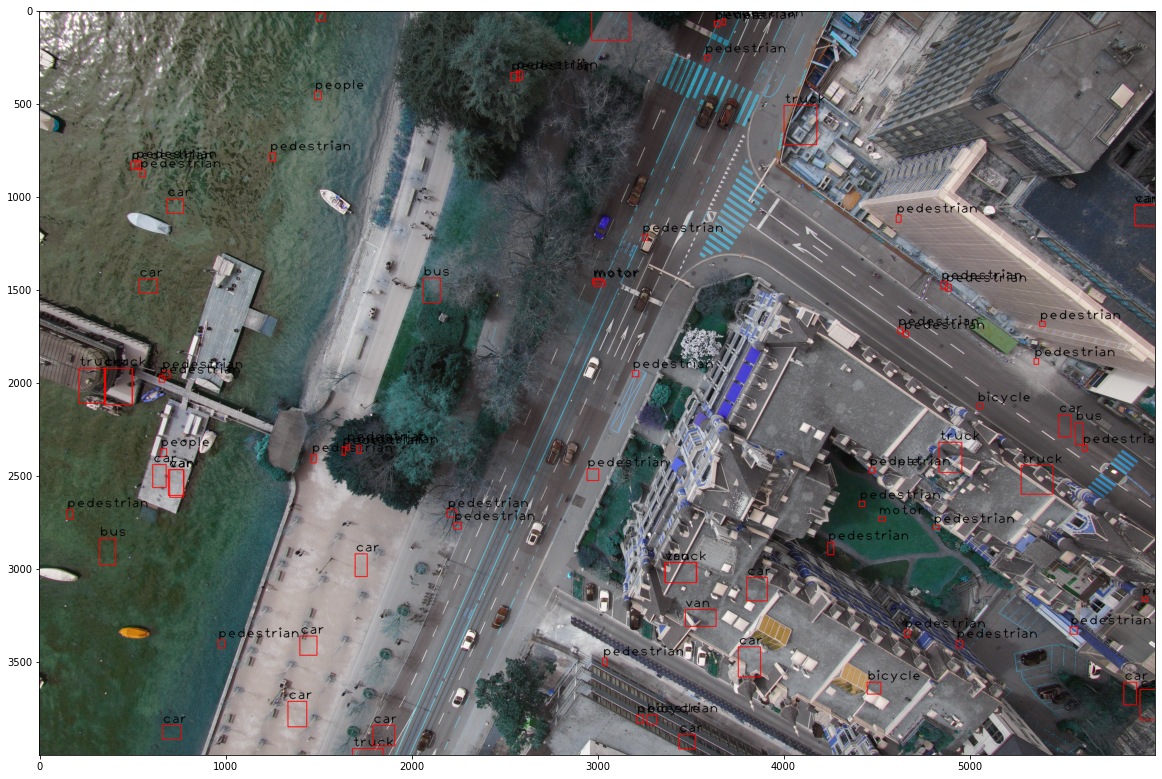

In [7]:
import cv2
def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 5, (0, 0, 0), 4)
    #cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 10, (255, 255, 255), 1)


for obj in detected_objects:
    x1 = obj['x1']
    y1 = obj['y1']
    x2 = obj['x2']
    y2 = obj['y2']
    caption = obj['Label']
    draw_caption(img, (x1, y1, x2, y2), caption)
    cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=4)
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #cv2.imshow('detections', img)




